# Little Helper

<center>

*machine learning tools are too much for such task*

</center>
<br>
<br>
<br>

That's hard but necesary to trace a path, in the first section explore diverses technics to measure text similarity

---

* More information abouth the distances in:
    * https://www.mdpi.com/2078-2489/11/9/421/htm#:~:text=2.3.&text=In%20word%20mover's%20distance%2C%20Euclidean,is%20not%20taken%20into%20account.

<html>
<img src="https://www.mdpi.com/information/information-11-00421/article_deploy/html/images/information-11-00421-g001.png" alt="Distance Clasifications" style="height: 700px; width:700px;"/>

Proposed Exploration:


1. Compare as Text Representation
    * The corpus, graph and semantic group can not be used by obvious reasons
    * Then in the string based group, i see the Jaccard, is cheap and very well documented
2. Compare by Text Distance
    * The semantic and distribution distances can not be used by obvious reasons
    * In the length Distance we have the Hamming distance and can be analized bit by bit the diferences

**Testing**

In [2]:
# install is you dont have. Py 3.11 issues
#!pip install openpyxl

In [3]:
import TextTools as tt
import pandas as pd
#import openpyxl
import seaborn as sns

In [4]:
X = "FLAME OF OLYMPUS CE"
Y = "Flame of Olympus"
Xd = tt.decimalToBinary(X)
Yd = tt.decimalToBinary(Y)
count=0
i = len(X)
j = len(Y)

### **Longest common substring problem**

In [5]:

tt.lcs(i,j,Xd,Yd,0)
# Canceled after 2 min, really nice, but really expensive

### **Jaccard of parts**

In [6]:
print(tt.JaccardDistance(X,Y))
print(tt.JaccardDistance(X[:int(len(X)*0.5)], Y[:int(len(Y)*0.5)]))
print(tt.JaccardDistance(X[int(len(X)*0.5):], Y[int(len(Y)*0.5):]))
#print(tt.HammingDistance(X,Y)) # Constant 0 fail
print(tt.HammingDistance(Xd,Yd))
print(tt.HammingDistance(Xd[:int(len(Xd)*0.5)], Yd[:int(len(Yd)*0.5)]))
print(tt.HammingDistance(Xd[int(len(Xd)*0.5):], Yd[int(len(Yd)*0.5):]))

0.9166666666666666
1.0
0.8
12.00000001
6.00000001
32.00000001


### **Hamming Distance**

In [7]:
LocalDistance={}
for i in range(len(X)):
    if i > 1:
        yb = tt.decimalToBinary(Y[0:i])
        xb = tt.decimalToBinary(X[0:i])    
        LocalDistance[i]=tt.HammingDistance(xb,yb)
#
Ld=pd.DataFrame(data=LocalDistance.values(), columns=['LocalDistance'], index=LocalDistance.keys())

**Ratio of change**

Calculate de ROC of distance in the characters of the title and their density to explore the hamming distance

In [8]:
Roc=[]
for i in range(len(Ld.LocalDistance)):
    if i > 2:
        Roc.append(Ld.LocalDistance[i]/Ld.LocalDistance[i-1])
    else:
        Roc.append(0)
Ld['Roc']=Roc

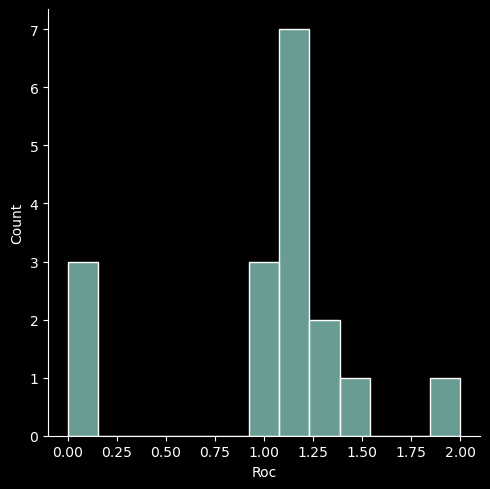

In [9]:
# distributions of data
sns.displot(Ld, x="Roc")

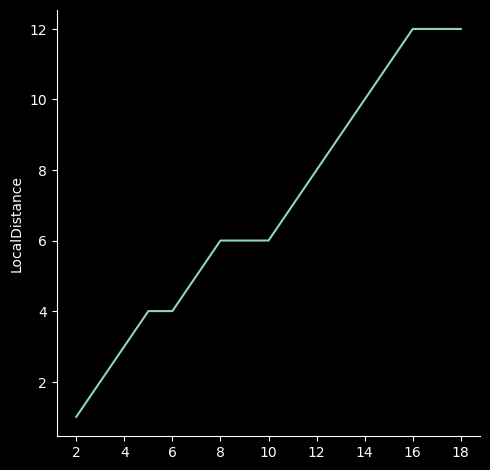

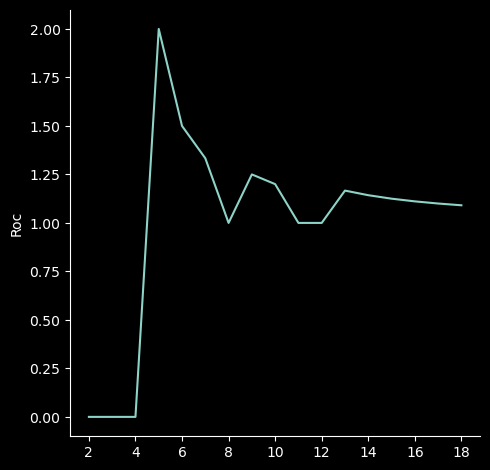

In [10]:
#
sns.relplot(data=Ld, x=Ld.index, y="LocalDistance", kind="line")
sns.relplot(data=Ld, x=Ld.index, y="Roc", kind="line")

In [11]:
x=Ld.groupby(by='Roc').count()
x

,LocalDistance
Roc,
0.000000,3
1.000000,3
1.090909,1
1.100000,1
1.111111,1
1.125000,1
1.142857,1
1.166667,1
1.200000,1


In [12]:
Ld.head(3)

,LocalDistance,Roc
2,1.0,0.0
3,2.0,0.0
4,3.0,0.0


In [13]:
x = Ld[Ld.LocalDistance==Ld.LocalDistance.min()]
x.index.max()

2

In [14]:
LastCommonStrings= Ld[Ld.Roc==Ld.Roc.max() ].index
LastCommonStrings

Int64Index([5], dtype='int64')

In [15]:
print('The "common" strings are:', X[int(LastCommonStrings[-1]-LastCommonStrings[0]-3):int(x.index.max()-2)] )

The "common" strings are: 


* i can see how the Hamming distance detect better the part that is diferent, is more sensible to the diferences.
* The next step is construct a dataset with the diferent distances
* Detect the "common right option" in the density of probabilities.

---

## **Let's use the data**

In [16]:
raw = pd.read_excel('Titles.xlsx')

In [17]:
raw.shape

(25732, 4)

In [18]:
raw.head()

,GP_Title,Title,Unnamed: 2,Unnamed: 3
0,NaN,HOWLING 7,NaN,NaN
1,Golden Zodiac,Golden Zodiac,NaN,NaN
2,100 LIONS,100 LIONS,NaN,NaN
3,200C Macaw Magic,Macaw Magic,NaN,NaN
4,5 DRAGONS,5 Dragons,NaN,NaN


In [19]:
raw.pop(raw.columns[2])
raw.pop(raw.columns[2])
raw.shape

(25732, 2)

In [20]:
raw.head(2)

,GP_Title,Title
0,NaN,HOWLING 7
1,Golden Zodiac,Golden Zodiac


In [21]:
raw[raw['GP_Title'].isnull()]

,GP_Title,Title
0,NaN,HOWLING 7
201,NaN,NaN


In [22]:
#Drop Nulls
raw.dropna(thresh=1, inplace=True)
raw.dropna(thresh=2, inplace=True)

In [23]:
raw[raw['GP_Title'].isnull()].count()

GP_Title    0
Title       0
dtype: int64

In [24]:
raw.head()

,GP_Title,Title
1,Golden Zodiac,Golden Zodiac
2,100 LIONS,100 LIONS
3,200C Macaw Magic,Macaw Magic
4,5 DRAGONS,5 Dragons
5,5 DRAGONS CE,5 Dragons


Once the null values are removed, I proceed to:

1. Create the reference list (dictionary)
2. Calculate the distances of each row and thus select the possible options

### Diccionario

In [25]:
df=raw

In [26]:
TitlesList = pd.Series(df.groupby('Title').count().index, copy=True)
TitlesList.to_excel('TitlesList.xlsx')


In [27]:
print('i have', df.groupby('Title').count().shape[0], 'ditinct games or consoles')

i have 1060 ditinct games or consoles


## Distances

### Hamming Distance

In [28]:
Suggested={}
iter=0
for i in df.GP_Title:
    if iter < 10:
        Comparison={}
        for j in df.Title:
            Xd = tt.decimalToBinary(str(i))
            Yd = tt.decimalToBinary(str(j))
            Comparison[j]=(tt.HammingDistance(Xd,Yd))
        Suggested[i] = min(zip(Comparison.values(), Comparison.keys()))[1]
    iter=iter+1

In [29]:
Suggested

{'  Golden Zodiac': '5 Koi',
 ' 100 LIONS': 'Ji',
 ' 200C  Macaw  Magic': 'Ji',
 ' 5 DRAGONS  ': 'Ji',
 ' 5 DRAGONS CE': 'Ji',
 ' 5 DRAGONS LEGENDS': 'Ji',
 ' 5 DRAGONS RP': 'Ji',
 ' 50 Lions          ': '100 LIONS',
 ' 50 LIONS (1C/2L)': '100 LIONS',
 ' 50 LIONS (CELL)': '100 LIONS'}

Jajajajajaj, No way

---


### Jaccard Distance

In [30]:
Suggested={}
iter=0
for i in df.GP_Title:
    if iter < 10:
        Comparison={}
        for j in df.Title:
            Comparison[j]=(tt.JaccardDistance(i,j))
        Suggested[i] = max(zip(Comparison.values(), Comparison.keys()))[1]
    iter=iter+1

In [31]:
# Supplied: Suggested
Suggested

{'  Golden Zodiac': 'Golden Zodiac',
 ' 100 LIONS': '100 LIONS',
 ' 200C  Macaw  Magic': 'Macaw Magic',
 ' 5 DRAGONS  ': '5 Dragons Grand',
 ' 5 DRAGONS CE': '5 Dragons Legends',
 ' 5 DRAGONS LEGENDS': '5 Dragons Legends',
 ' 5 DRAGONS RP': '5 Dragons Rapid',
 ' 50 Lions          ': '50 Lions',
 ' 50 LIONS (1C/2L)': '50 Lions',
 ' 50 LIONS (CELL)': '50 Lions'}

In [32]:
# Correct
#
df.Title[0:10]

C:\Users\ochoa\AppData\Local\Temp\ipykernel_2744\57800971.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df.Title[0:10]


1         Golden Zodiac
2             100 LIONS
3           Macaw Magic
4             5 Dragons
5             5 Dragons
6     5 Dragons Legends
7       5 Dragons Rapid
8              50 Lions
9              50 Lions
10             50 Lions
Name: Title, dtype: object

That is nice, now i try to refine it

---

In [33]:
import statistics

In [34]:
Suggested={}
iter=0
for i in df.GP_Title:
    if iter < 10:
        ComparisonFull={}
        ComparisonFirst={}
        ComparisonMiddle={}
        for j in df.Title:
            ComparisonFull[j]=(tt.JaccardDistance(i,j))
            ComparisonMiddle[j]=(tt.JaccardDistance(X[int(len(X)*0.25):int(len(X)*0.75)], Y[int(len(Y)*0.25):int(len(Y)*0.75)]))
            ComparisonFirst[j]=(tt.JaccardDistance(X[:int(len(X)*0.5)], Y[:int(len(Y)*0.5)]))
            Voting = [ max(zip(ComparisonFull.values(), ComparisonFull.keys()))[1], max(zip(ComparisonFirst.values(), ComparisonFirst.keys()))[1], max(zip(ComparisonMiddle.values(), ComparisonMiddle.keys()))[1]]
        Suggested[i] = max(set(Voting), key = Voting.count)
    iter=iter+1

In [35]:
Voting

['50 Lions',
 'Zorro: The Tale of the Lost Gold',
 'Zorro: The Tale of the Lost Gold']

In [36]:
Suggested

{'  Golden Zodiac': 'Zorro: The Tale of the Lost Gold',
 ' 100 LIONS': 'Zorro: The Tale of the Lost Gold',
 ' 200C  Macaw  Magic': 'Zorro: The Tale of the Lost Gold',
 ' 5 DRAGONS  ': 'Zorro: The Tale of the Lost Gold',
 ' 5 DRAGONS CE': 'Zorro: The Tale of the Lost Gold',
 ' 5 DRAGONS LEGENDS': 'Zorro: The Tale of the Lost Gold',
 ' 5 DRAGONS RP': 'Zorro: The Tale of the Lost Gold',
 ' 50 Lions          ': 'Zorro: The Tale of the Lost Gold',
 ' 50 LIONS (1C/2L)': 'Zorro: The Tale of the Lost Gold',
 ' 50 LIONS (CELL)': 'Zorro: The Tale of the Lost Gold'}

---

### Evaluation

The classical Jaccard approximation in the whole sentence seems to be the most accurate option and one of the most computationally economical. Wait an hour to evaluate the dataset

In [37]:
import MungingOps as ops

In [ ]:
# Eliminamos los limites en la evaluacion
#
Suggested=[]
iter=0
for i in df.GP_Title:
    if iter < 1000000:
        # Limpiamos datos
        i= i.lower()
        try:
            i=i.replace(' and ',' ')
        except: None
        try:
            i=i.replace(' & ','')
        except: None
        try:
            i=i.replace(':','')
        except: None
        try:
            i=i.replace('"','')
        except: None
        try:
            i=i.replace('one','1')
        except: None
        try:
            i=i.replace('II','2')
        except: None
        try:
            i=i.replace('III','3')
        except: None
        try:
            i=i.replace('IV','4')
        except: None
        try:
            i=i.replace(')','')
        except: None
        try:
            i=i.replace('(','')
        except: None
        try:
            i=i.replace('-','')
        except: None
        try:
            i=ops.ExtraWhite(i)
        except: None
        Comparison={}
        for j in df.Title:
            Comparison[j]=(tt.JaccardDistance(i,j))
        Suggested.append(max(zip(Comparison.values(), Comparison.keys()))[1])
        iter=iter+1

In [328]:
df['Suggested']=Suggested

In [329]:
df.to_excel('TitleTest.xlsx')
df.head(15)

,GP_Title,Title,Suggested
1,Golden Zodiac,Golden Zodiac,Golden Zodiac
2,100 LIONS,100 LIONS,100 LIONS
3,200C Macaw Magic,Macaw Magic,Macaw Magic
4,5 DRAGONS,5 Dragons,5 Dragons Grand
5,5 DRAGONS CE,5 Dragons,5 Dragons Legends
6,5 DRAGONS LEGENDS,5 Dragons Legends,5 Dragons Legends
7,5 DRAGONS RP,5 Dragons Rapid,5 Dragons Rapid
8,50 Lions,50 Lions,50 Lions
9,50 LIONS (1C/2L),50 Lions,50 Lions
10,50 LIONS (CELL),50 Lions,50 Lions


In [331]:
df.groupby(by='GP_Title').count().shape[0]

25652

## Conclusion

I use the jaccard distance, is more or less exactly and cheap